
# **Calculating WMD and Cosine Score for JSTOR Article Samples**



Computational Literature Review

Creator: Nancy Xu

Date created: September 6, 2022

Date last modified: September 21, 2022

This notebook:
- generates 20 samples of articles in positive/negative classes for each of the 3 perspectives
- calculates Word Mover's Distance (using a gensim Word2Vec model) between an article and core seed terms
- calculates cosine similarity between an article (represented by average of Word2Vec embeddings of its tokens) and average vector of core seed terms (represented by a Word2Vec embedding)
- compares the distribution of WMD scores and cosine similarity scores for each positive/negative perspective

Files used:
- labeled data
    - /home/jovyan/work/models_storage/preprocessed_texts/training_relational_preprocessed_100321.pkl
    - /home/jovyan/work/models_storage/preprocessed_texts/training_demographic_preprocessed_100321.pkl
    - /home/jovyan/work/models_storage/preprocessed_texts/training_orgs_preprocessed_100321.pkl
    - /home/jovyan/work/models_storage/preprocessed_texts/training_cultural_preprocessed_100321.pkl
- seed terms:
    - demographic_core.txt
    - relational_core.txt
    - cultural_core.txt
    
- word2vec phased model
    - models_storage/tree/master/w2v_models/word2vec_phrased_filtered_300d_2020_sept5.bin

In [11]:
import pandas as pd
import gensim
import pickle
import os
import re
import ast
from gensim.models.phrases import Phrases
from gensim.models.phrases import Phrases, Phraser
import multiprocessing
from sklearn import utils
cores = multiprocessing.cpu_count()
import gensim
from gensim.test.utils import get_tmpfile
from gensim.models import Word2Vec
from tqdm import tqdm
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import common_texts
from numpy import dot, absolute
from numpy.linalg import norm
import numpy as np

## Text preprocessing & train phrased Word2Vec model

Load in and preprocess dataframes for each perspective.

In [ ]:
os.chdir('/home/jovyan/work/models_storage/preprocessed_texts')
def open_test_data(path):
    return open(path, 'rb')
with open_test_data('training_relational_preprocessed_100321.pkl') as f:
    rela = pickle.load(f)

with open_test_data('training_demographic_preprocessed_100321.pkl') as f:
    demog = pickle.load(f)

with open_test_data('training_orgs_preprocessed_100321.pkl') as f:
    orgs = pickle.load(f)

with open_test_data('training_cultural_preprocessed_100321.pkl') as f:
    cult = pickle.load(f)
    

import itertools
full_text = []

for i in cult['text']:
    joined = list(itertools.chain(*i))
    full_text.append(" ".join(joined))

full_text_demog = []
for i in demog['text']:
    joined = list(itertools.chain(*i))
    full_text_demog.append(" ".join(joined))

full_text_orgs = []
for j in orgs['text']:
    joined = list(itertools.chain(*j))
    full_text_orgs.append(" ".join(joined))

full_text_rela = []
for j in rela['text']:
    joined = list(itertools.chain(*j))
    full_text_rela.append(" ".join(joined))

cult['full_text'] = full_text
demog['full_text'] = full_text_demog
orgs['full_text'] = full_text_orgs
rela['full_text'] = full_text_rela

def remove_tags(article):
    article = re.sub('<plain_text> <page sequence="1">', '', article)
    article = re.sub(r'</page>(\<.*?\>)', ' \n ', article)
    # xml tags
    article = re.sub(r'<.*?>', '', article)
    article = re.sub(r'<body.*\n\s*.*\s*.*>', '', article)
    return article

tags_removed = [remove_tags(art) for art in cult['full_text']]
tags_removed_demog = [remove_tags(art) for art in demog['full_text']]
tags_removed_org = [remove_tags(art) for art in orgs['full_text']]
tags_removed_rela = [remove_tags(art) for art in rela['full_text']]
cult['text_no_tags'] = tags_removed
demog['text_no_tags'] = tags_removed_demog
orgs['text_no_tags'] = tags_removed_org
rela['text_no_tags'] = tags_removed_rela

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['one', 'two', 'three', 'amp', 'may', 'can', 'new', 'also', 'and'])

import string
import re
import nltk

def word_process(tt):
    """
    helper function to lower text, remove stop words, numbers, and empty 
    """
    
    tt = tt.lower()
    
    punc = '''!()-[]{};:'"\, <>./?@#$%^&*_~=\n'''
    # Removing punctuations in string 
    # Using loop + punctuation string 


    for ele in tt:  
        if ele in punc:  
            tt = tt.replace(ele, " ")  

    # read tokens
    tokens = tt.split()
    lst = [token.translate(punc).lower() for token in tokens ]
    
    #remove stop words
    filtered = []
    for i in lst:
        if i not in stop_words:
            filtered.append(i)
    
    # removing singular numbers and singular letters
    pattern = '[0-9]'
    filtered = [re.sub(pattern, '', i) for i in filtered] 
    new = []
    for inp in filtered:
        new.append(' '.join( [w for w in inp.split() if len(w)>1] ))
        
    # filter out empty strings 
    new = [i for i in new if i] 

    dt = [d.split() for d in new]
    
  
    st = ''
    for i in dt:
        st = st + " " + i[0]
    return st
    

cult['processed']  =  cult['text_no_tags'].apply(word_process)
rela['processed']  =  rela['text_no_tags'].apply(word_process)
demog['processed']  =  demog['text_no_tags'].apply(word_process)
orgs['processed']  =  orgs['text_no_tags'].apply(word_process)

cult_pos = cult[cult['cultural_score']==1]
cult_neg = cult[cult['cultural_score']==0]

rela_pos = rela[rela['relational_score']==1]
rela_neg = rela[rela['relational_score']==0]

demog_pos = demog[demog['demographic_score']==1]
demog_neg = demog[demog['demographic_score']==0]

pos_cult = cult_pos.sample(20, replace = False)
neg_cult = cult_neg.sample(20, replace = False)

pos_rela = rela_pos.sample(20, replace = False)
neg_rela = rela_neg.sample(20, replace = False)

pos_demog = demog_pos.sample(20, replace = False)
neg_demog = demog_neg.sample(20, replace = False)

pos_cult.to_csv('/home/jovyan/work/nancyxu/pos_cult.csv')
neg_cult.to_csv('/home/jovyan/work/nancyxu/neg_cult.csv')
pos_rela.to_csv('/home/jovyan/work/nancyxu/pos_rela.csv')
neg_rela.to_csv('/home/jovyan/work/nancyxu/neg_rela.csv')
pos_demog.to_csv('/home/jovyan/work/nancyxu/pos_demog.csv')
neg_demog.to_csv('/home/jovyan/work/nancyxu/neg_demog.csv')


In [ ]:
pos_cult = pd.read_csv('pos_cult.csv')
neg_cult = pd.read_csv('neg_cult.csv')
pos_rela = pd.read_csv('pos_rela.csv')
neg_rela = pd.read_csv('neg_rela.csv')
pos_demog = pd.read_csv('pos_demog.csv')
neg_demog = pd.read_csv('neg_demog.csv')

load in pretrained phrased w2v model

In [ ]:
w2v=Word2Vec.load('word2vec_phrased_filtered_300d_2020_sept5.bin')

In [ ]:
# import numpy as np
# def find_mean_and_closest_article(article,df,topk):
#     """
#     calcalate the mean wmd of a certain article from other articles in the same perspective,
#     then give the top k closest articles in the same perspective.
#     """
#     d = []
#     for i in np.arange(len(df)):
#         d.append(calc_wmd(article,df.loc[i,'processed']))
#     dis_dict = pd.DataFrame(list(zip(d,df['processed'])), columns = ['distance', 'article'])
#     dis_dict['full_text'] = df['full_text']
#     dis_dict['edited_filename'] = df['edited_filename'] 
#     dis_dict = dis_dict[dis_dict['article']!=article]
#     srted = dis_dict.sort_values('distance').head(topk)

#     return np.mean(dis_dict['distance']), tuple(zip(srted['edited_filename'], srted['distance']))
        
# def get_cols_sims(df):
#     """
#     get mean wmd similarity scores 
#     """
#     results = pos_cult['processed'].apply(lambda x: find_closest_article(x,pos_cult,10))
#     mean_sims_score = [i[0] for i in results]
#     top10_sims_articles = [i[1] for i in results]
#     df['mean_sims_score'] = mean_sims_score
#     df['top10_sims_articles'] = top10_sims_articles
#     return df.sort_values('mean_sims_score')

## Compute WMD between an article and perspective seed terms

reference: https://radimrehurek.com/gensim/auto_examples/tutorials/run_wmd.html

In [ ]:
def calc_wmd(a,b):
    return w2v.wmdistance(a,b)

In [ ]:
def read_txt_lst(file):
    txt_file = open(file, "r")
    file_content = txt_file.read()
    # print("The file content are: ", file_content)

    content_list = file_content.split("\n")
    txt_file.close()
    return content_list

In [ ]:
dem_core=read_txt_lst('demographic_core.txt')
rela_core=read_txt_lst('relational_core.txt')
cult_core = read_txt_lst('cultural_core.txt')

In [ ]:
dem_core=[re.sub(r'\s','_',x) for x in dem_core]
rela_core=[re.sub(r'\s','_',x) for x in rela_core]
cult_core=[re.sub(r'\s','_',x) for x in cult_core]

In [ ]:

def build_phrases(sentences):
    phrases = Phrases(sentences, min_count = 5, threshold = 7, progress_per = 1000)
    return Phraser(phrases)

In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
def get_sims_with_perspective(article):
  """
  get wmd similarity between this article and the core terms of each perspective
  """

  ## first build bigram from the article

  article_tokens = article.split()

#   article_tokens = word_tokenize(article)
    
  dem_score = calc_wmd(article_tokens,(dem_core))
  rela_score = calc_wmd(article_tokens,(rela_core))
  cult_score = calc_wmd(article_tokens,(cult_core))
  return (dem_score,rela_score,cult_score)

In [ ]:
get_sims_with_perspective(pos_cult.loc[0,'processed'])

In [ ]:
get_sims_with_perspective(neg_rela.loc[0,'processed'])

In [ ]:

def get_sim_perspective(df):

    """
    returns modified df with extra columns dem_score,rela_score,cult_score
    denoting the wmd score calculated for each article.
    """
    tqdm.pandas()

    results=df['processed'].apply(lambda x:get_sims_with_perspective(x))
    dem_scores = [i[0] for i in results]
    rela_scores = [i[1] for i in results]
    cult_scores = [i[2] for i in results]
    df['dem_scores'] = dem_scores
    df['rela_scores'] = rela_scores
    df['cult_scores']= cult_scores
    return df

In [ ]:
pos_cult = get_sim_perspective(pos_cult)
neg_cult = get_sim_perspective(neg_cult)

pos_demog = get_sim_perspective(pos_demog)
neg_demog = get_sim_perspective(neg_demog)

pos_rela = get_sim_perspective(pos_rela)
neg_rela = get_sim_perspective(neg_rela)

In [ ]:
pos_cult=pos_cult.rename(columns={'dem_scores':'dem_wmd', 'rela_scores':'rela_wmd', 'cult_scores':'cult_wmd'})
neg_cult=neg_cult.rename(columns={'dem_scores':'dem_wmd', 'rela_scores':'rela_wmd', 'cult_scores':'cult_wmd'})

pos_demog=pos_demog.rename(columns={'dem_scores':'dem_wmd', 'rela_scores':'rela_wmd', 'cult_scores':'cult_wmd'})
neg_demog=neg_demog.rename(columns={'dem_scores':'dem_wmd', 'rela_scores':'rela_wmd', 'cult_scores':'cult_wmd'})

pos_rela=pos_rela.rename(columns={'dem_scores':'dem_wmd', 'rela_scores':'rela_wmd', 'cult_scores':'cult_wmd'})
neg_rela=neg_rela.rename(columns={'dem_scores':'dem_wmd', 'rela_scores':'rela_wmd', 'cult_scores':'cult_wmd'})

In [ ]:
pos_demog

## Calculate cosine similarity score between the article and each perspective

Using Word2Vec to get vector representations of the text in each jstor article, average them to get the article embedding, then calculate cosine similarity between the embedding of each article and average w2v vector for each perspective.

reference: https://github.com/h2researchgroup/embeddings/blob/main/preprocessing/cosine_values_calculate_word2vec.py

In [ ]:
cult_core_embs=[]
for x in cult_core:
  try:
    cult_core_embs.append(w2v.wv[x])
  except:
    pass


In [ ]:
demog_core_embs=[]
for x in dem_core:
  try:
    demog_core_embs.append(w2v.wv[x])
  except:
    pass


In [ ]:
rela_core_embs=[]
for x in rela_core:
  try:
    rela_core_embs.append(w2v.wv[x])
  except:
    pass


In [ ]:
import numpy as np
rela_core_embs_mean = np.mean(rela_core_embs, axis=0)
cult_core_embs_mean = np.mean(cult_core_embs, axis=0)
demog_core_embs_mean = np.mean(demog_core_embs, axis=0)

In [ ]:
def doc_words_cosine(doc):
    """
  doc = str of text
  get cosine similarity scores between the document embedding and average emb of the core terms in each perspective.
  """
    ss = [doc.split()]
    bb = build_phrases(ss)
    pb = [bb[i] for i in ss][0]
    article_embs=[]
    for k in pb:
      try:
        article_embs.append(w2v.wv[k])
      except:
        pass
    doc_vec = np.mean(np.array(article_embs), axis=0)
    cult_sim = absolute(dot(doc_vec, cult_core_embs_mean)/(norm(doc_vec)*norm(cult_core_embs_mean)))
    rela_sim = absolute(dot(doc_vec, rela_core_embs_mean)/(norm(doc_vec)*norm(rela_core_embs_mean)))
    demog_sim = absolute(dot(doc_vec, demog_core_embs_mean)/(norm(doc_vec)*norm(demog_core_embs_mean)))
    return (demog_sim,rela_sim,cult_sim)

In [ ]:
def apply_doc_words_cosine(df):

  """
  applies doc_words_cosine on the processed texts in each df
  returns modified df with new columns dem_sim,rela_sim,cult_sim
  """

  results=df['processed'].apply(lambda x:doc_words_cosine(x))
  dem_scores = [i[0] for i in results]
  rela_scores = [i[1] for i in results]
  cult_scores = [i[2] for i in results]
  df['dem_sim'] = dem_scores
  df['rela_sim'] = rela_scores
  df['cult_sim']= cult_scores

  return df

In [ ]:
pos_cult = apply_doc_words_cosine(pos_cult)
neg_cult = apply_doc_words_cosine(neg_cult)

pos_demog = apply_doc_words_cosine(pos_demog)
neg_demog = apply_doc_words_cosine(neg_demog)

pos_rela = apply_doc_words_cosine(pos_rela)
neg_rela = apply_doc_words_cosine(neg_rela)

In [ ]:
neg_rela

To classify an article with WMD, get the perspective with the smallest distance.

In [ ]:
pos_rela['classified_perspective_wmd']=pos_rela.apply(lambda x:np.argmin([x.dem_wmd,x.rela_wmd,x.cult_wmd]),axis=1)
neg_rela['classified_perspective_wmd']=neg_rela.apply(lambda x:np.argmin([x.dem_wmd,x.rela_wmd,x.cult_wmd]),axis=1)
pos_cult['classified_perspective_wmd']=pos_cult.apply(lambda x:np.argmin([x.dem_wmd,x.rela_wmd,x.cult_wmd]),axis=1)
neg_cult['classified_perspective_wmd']=neg_cult.apply(lambda x:np.argmin([x.dem_wmd,x.rela_wmd,x.cult_wmd]),axis=1)
pos_demog['classified_perspective_wmd']=pos_demog.apply(lambda x:np.argmin([x.dem_wmd,x.rela_wmd,x.cult_wmd]),axis=1)
neg_demog['classified_perspective_wmd']=neg_demog.apply(lambda x:np.argmin([x.dem_wmd,x.rela_wmd,x.cult_wmd]),axis=1)

In [ ]:
perspective_dict={0:'demographic', 1:'relational', 2:'cultural'}

In [ ]:
pos_rela['classified_perspective_wmd'] = pos_rela['classified_perspective_wmd'].replace(perspective_dict)
neg_rela['classified_perspective_wmd'] = neg_rela['classified_perspective_wmd'].replace(perspective_dict)
pos_cult['classified_perspective_wmd'] = pos_cult['classified_perspective_wmd'].replace(perspective_dict)
neg_cult['classified_perspective_wmd'] = neg_cult['classified_perspective_wmd'].replace(perspective_dict)
pos_demog['classified_perspective_wmd'] = pos_demog['classified_perspective_wmd'].replace(perspective_dict)
neg_demog['classified_perspective_wmd'] = neg_demog['classified_perspective_wmd'].replace(perspective_dict)

To classify an article with cosine similarity, get the perspective with the biggest cosine similarity.

In [ ]:
pos_rela['classified_perspective_cos']=pos_rela.apply(lambda x:np.argmax([x.dem_sim,x.rela_sim,x.cult_sim]),axis=1)
neg_rela['classified_perspective_cos']=neg_rela.apply(lambda x:np.argmax([x.dem_sim,x.rela_sim,x.cult_sim]),axis=1)
pos_cult['classified_perspective_cos']=pos_cult.apply(lambda x:np.argmax([x.dem_sim,x.rela_sim,x.cult_sim]),axis=1)
neg_cult['classified_perspective_cos']=neg_cult.apply(lambda x:np.argmax([x.dem_sim,x.rela_sim,x.cult_sim]),axis=1)
pos_demog['classified_perspective_cos']=pos_demog.apply(lambda x:np.argmax([x.dem_sim,x.rela_sim,x.cult_sim]),axis=1)
neg_demog['classified_perspective_cos']=neg_demog.apply(lambda x:np.argmax([x.dem_sim,x.rela_sim,x.cult_sim]),axis=1)

In [ ]:
pos_rela['classified_perspective_cos'] = pos_rela['classified_perspective_cos'].replace(perspective_dict)
neg_rela['classified_perspective_cos'] = neg_rela['classified_perspective_cos'].replace(perspective_dict)
pos_cult['classified_perspective_cos'] = pos_cult['classified_perspective_cos'].replace(perspective_dict)
neg_cult['classified_perspective_cos'] = neg_cult['classified_perspective_cos'].replace(perspective_dict)
pos_demog['classified_perspective_cos'] = pos_demog['classified_perspective_cos'].replace(perspective_dict)
neg_demog['classified_perspective_cos'] = neg_demog['classified_perspective_cos'].replace(perspective_dict)

In [ ]:
pos_cult=pos_cult.rename(columns={'dem_sim':'dem_cos_sim', 'rela_sim':'rela_cos_sim', 'cult_sim':'cult_cos_sim'})
neg_cult=neg_cult.rename(columns={'dem_sim':'dem_cos_sim', 'rela_sim':'rela_cos_sim', 'cult_sim':'cult_cos_sim'})

pos_demog=pos_demog.rename(columns={'dem_sim':'dem_cos_sim', 'rela_sim':'rela_cos_sim', 'cult_sim':'cult_cos_sim'})
neg_demog=neg_demog.rename(columns={'dem_sim':'dem_cos_sim', 'rela_sim':'rela_cos_sim', 'cult_sim':'cult_cos_sim'})

pos_rela=pos_rela.rename(columns={'dem_sim':'dem_cos_sim', 'rela_sim':'rela_cos_sim', 'cult_sim':'cult_cos_sim'})
neg_rela=neg_rela.rename(columns={'dem_sim':'dem_cos_sim', 'rela_sim':'rela_cos_sim', 'cult_sim':'cult_cos_sim'})

In [ ]:
from sklearn.preprocessing import normalize
def normalize_invert_wmd(df):
    """
    normalize the wmd, then invert it (1- normalized wmd),
    also normalize cosine simiarlity score.
    
    """
    dem_wmd=df.dem_wmd
    rela_wmd=df.rela_wmd
    cult_wmd=df.cult_wmd
    
    dem_cos = df.dem_cos_sim
    rela_cos = df.rela_cos_sim
    cult_cos = df.cult_cos_sim
    
    normalized_dem_wmd,normalized_rela_wmd,normalized_cult_wmd = [],[],[]
    normalized_dem_cos,normalized_rela_cos,normalized_cult_cos = [],[],[]
    
    for i in np.arange(len(df)):
        normalized_inverted_3_scores_wmd = 1 - normalize([[dem_wmd[i],rela_wmd[i], cult_wmd[i]]])
#         print(normalized_inverted_3_scores)
        normalized_dem_wmd.append(normalized_inverted_3_scores_wmd[0][0])
        normalized_rela_wmd.append(normalized_inverted_3_scores_wmd[0][1])
        normalized_cult_wmd.append(normalized_inverted_3_scores_wmd[0][2])
        
        normalized_inverted_3_scores_cos = normalize([[dem_cos[i],rela_cos[i], cult_cos[i]]])
        
        normalized_dem_cos.append(normalized_inverted_3_scores_cos[0][0])
        normalized_rela_cos.append(normalized_inverted_3_scores_cos[0][1])
        normalized_cult_cos.append(normalized_inverted_3_scores_cos[0][2])
        
    df['normalized_dem_wmd']=normalized_dem_wmd
    df['normalized_rela_wmd']=normalized_rela_wmd
    df['normalized_cult_wmd']=normalized_cult_wmd
    
    df['normalized_dem_cos']=normalized_dem_cos
    df['normalized_rela_cos']=normalized_rela_cos
    df['normalized_cult_cos']=normalized_cult_cos
    
    return df
        

In [ ]:
pos_cult

In [ ]:
dem_wmd=pos_cult.dem_wmd
rela_wmd=pos_cult.rela_wmd
cult_wmd=pos_cult.cult_wmd

dem_cos = pos_cult.dem_cos_sim
rela_cos = pos_cult.rela_cos_sim
cult_cos = pos_cult.cult_cos_sim

In [ ]:
dem_wmd

In [ ]:
pos_cult = normalize_invert_wmd(pos_cult)
neg_cult = normalize_invert_wmd(neg_cult)

pos_demog = normalize_invert_wmd(pos_demog)
neg_demog = normalize_invert_wmd(neg_demog)

pos_rela = normalize_invert_wmd(pos_rela)
neg_rela = normalize_invert_wmd(neg_rela)

In [ ]:
pos_rela

In [ ]:
keep_cols = ['edited_filename', 'article_name', 'processed','classified_perspective_wmd',
       'classified_perspective_cos', 'normalized_dem_wmd',
       'normalized_rela_wmd', 'normalized_cult_wmd', 'normalized_dem_cos',
       'normalized_rela_cos', 'normalized_cult_cos']

In [ ]:
pos_cult = pos_cult[keep_cols]
neg_cult = neg_cult[keep_cols]
pos_rela = pos_rela[keep_cols]
neg_rela = neg_rela[keep_cols]
pos_demog = pos_demog[keep_cols]
neg_demog = neg_demog[keep_cols]

In [ ]:
pos_cult.to_csv('pos_cult_sample_wmd_cos.csv')
neg_cult.to_csv('neg_cult_sample_wmd_cos.csv')
pos_demog.to_csv('pos_demog_sample_wmd_cos.csv')
neg_demog.to_csv('neg_demog_sample_wmd_cos.csv')
pos_rela.to_csv('pos_rela_sample_wmd_cos.csv')
neg_rela.to_csv('neg_rela_sample_wmd_cos.csv')

## Inspecting Distribution of Similarity Metrics

In [2]:
pos_cult=pd.read_csv('pos_cult_sample_wmd_cos.csv')
neg_cult=pd.read_csv('neg_cult_sample_wmd_cos.csv')
pos_demog = pd.read_csv('pos_demog_sample_wmd_cos.csv')
neg_demog = pd.read_csv('neg_demog_sample_wmd_cos.csv')
pos_rela = pd.read_csv('pos_rela_sample_wmd_cos.csv')
neg_rela = pd.read_csv('neg_rela_sample_wmd_cos.csv')

In [3]:
pos_cult

,Unnamed: 0,edited_filename,article_name,processed,classified_perspective_wmd,classified_perspective_cos,normalized_dem_wmd,normalized_rela_wmd,normalized_cult_wmd,normalized_dem_cos,normalized_rela_cos,normalized_cult_cos,cultural_score
0,0,10.2307_2393791,The Dynamics of Institutionalization: Transfor...,dynamics institutionalization transformation ...,cultural,cultural,0.400340,0.426599,0.441771,0.530715,0.596055,0.602545,1.0
1,1,10.2307_3086086,Capitalizing on Paradox: The Role of Language ...,capitalizing paradox role language transformi...,cultural,cultural,0.400013,0.423394,0.445436,0.531458,0.577613,0.619609,1.0
2,2,10.2307_26162677,Do (some) organizations cause their own crises...,industrial crisis quarterly elsevier science ...,cultural,cultural,0.399761,0.424079,0.444997,0.540425,0.589646,0.600215,1.0
3,3,10.2307_2391875,Educational Organizations as Loosely Coupled S...,educational organizations loosely coupled sys...,cultural,cultural,0.395996,0.425760,0.447345,0.527685,0.579211,0.621340,1.0
4,4,10.2307_2781778,"Conflict Management, Honor, and Organizational...",conflict management honor organizational chan...,cultural,relational,0.395293,0.432978,0.440701,0.508466,0.617219,0.600419,1.0
5,5,10.1086_210316,The Endogeneity of Legal Regulation: Grievance...,endogeneity legal regulation grievance proced...,cultural,cultural,0.400096,0.425367,0.443302,0.533039,0.583080,0.613096,1.0
6,6,10.1525_si.1993.16.1.65,\n,reflect america rain man las vegas action pos...,cultural,cultural,0.402088,0.422649,0.443972,0.528373,0.562441,0.635989,1.0
7,7,10.2307_2094525,Small Groups and Culture Creation: The Idiocul...,small groups culture creation idioculture lit...,cultural,cultural,0.397761,0.422390,0.448933,0.528273,0.576905,0.622983,1.0
8,8,10.1086_231293,Caveat Emptor: The Construction of Nonprofit C...,caveat emptor construction nonprofit consumer...,cultural,cultural,0.400378,0.424790,0.443595,0.542646,0.586974,0.600830,1.0
9,9,10.2307_2640266,Linking Organizational Values to Relationships...,linking organizational values relationships e...,cultural,relational,0.397579,0.429101,0.442181,0.534883,0.619557,0.574500,1.0


In [4]:
import matplotlib.pyplot as plt

In [5]:
from sklearn.preprocessing import normalize

#### Overlayed Distributions for WMD

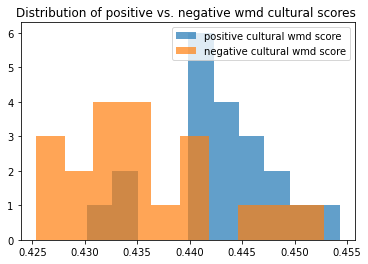

In [12]:
plt.hist(pos_cult['normalized_cult_wmd'], label = 'positive cultural wmd score', alpha = 0.7)
plt.hist(neg_cult['normalized_cult_wmd'], label = 'negative cultural wmd score', alpha = 0.7)
plt.title('Distribution of positive vs. negative wmd cultural scores ')
plt.legend()
plt.show()

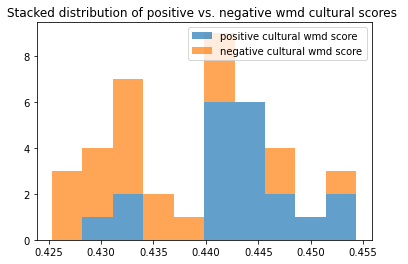

In [13]:
bins = np.arange(0.2,0.5,0.001)
labels = ['positive cultural wmd score','negative cultural wmd score']

plt.hist([pos_cult['normalized_cult_wmd'], neg_cult['normalized_cult_wmd']], histtype='bar', alpha = 0.7,stacked=True, label=labels, rwidth=1)
plt.title('Stacked distribution of positive vs. negative wmd cultural scores ')
plt.legend()



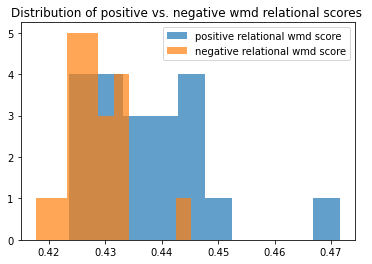

In [14]:
plt.hist(pos_rela['normalized_rela_wmd'], label = 'positive relational wmd score', alpha = 0.7)
plt.hist(neg_rela['normalized_rela_wmd'], label = 'negative relational wmd score', alpha = 0.7)
plt.title('Distribution of positive vs. negative wmd relational scores ')
plt.legend()
plt.show()

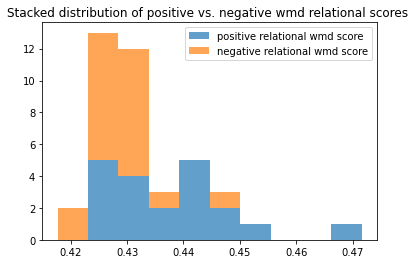

In [15]:
bins = np.arange(0.2,0.5,0.001)
labels = ['positive relational wmd score','negative relational wmd score']

plt.hist([pos_rela['normalized_rela_wmd'],neg_rela['normalized_rela_wmd']], histtype='bar', alpha = 0.7,stacked=True, label=labels, rwidth=1)
plt.title('Stacked distribution of positive vs. negative wmd relational scores ')
plt.legend()



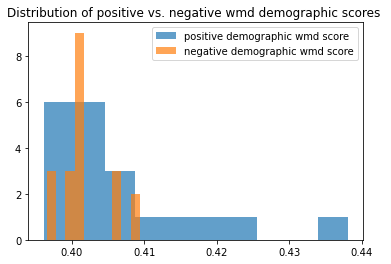

In [16]:
plt.hist(pos_demog['normalized_dem_wmd'], label = 'positive demographic wmd score', alpha = 0.7)
plt.hist(neg_demog['normalized_dem_wmd'], label = 'negative demographic wmd score', alpha = 0.7)
plt.title('Distribution of positive vs. negative wmd demographic scores ')
plt.legend()
plt.show()

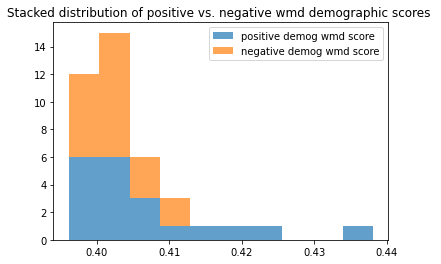

In [17]:
bins = np.arange(0.2,0.5,0.001)
labels = ['positive demog wmd score','negative demog wmd score']

plt.hist([pos_demog['normalized_dem_wmd'],neg_demog['normalized_dem_wmd']], histtype='bar', alpha = 0.7,stacked=True, label=labels, rwidth=1)
plt.title('Stacked distribution of positive vs. negative wmd demographic scores ')
plt.legend()



#### Overlayed Distributions for cosine

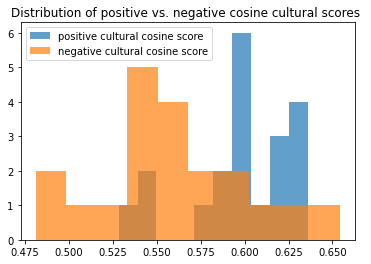

In [18]:
plt.hist(pos_cult['normalized_cult_cos'], label = 'positive cultural cosine score', alpha=0.7)
plt.hist(neg_cult['normalized_cult_cos'], label = 'negative cultural cosine score', alpha=0.7)
plt.title('Distribution of positive vs. negative cosine cultural scores ')
plt.legend()
plt.show()

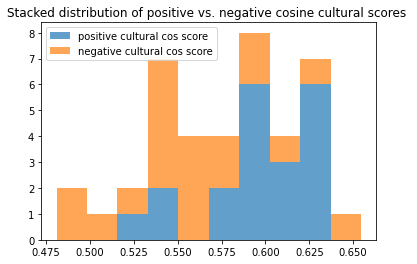

In [19]:
bins = np.arange(0.2,0.5,0.001)
labels = ['positive cultural cos score','negative cultural cos score']

plt.hist([pos_cult['normalized_cult_cos'],neg_cult['normalized_cult_cos']], histtype='bar', alpha = 0.7,stacked=True, label=labels, rwidth=1)
plt.title('Stacked distribution of positive vs. negative cosine cultural scores ')
plt.legend()



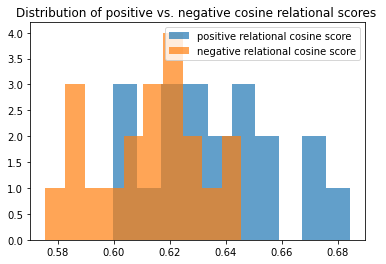

In [20]:
plt.hist(pos_rela['normalized_rela_cos'], label = 'positive relational cosine score', alpha = 0.7)
plt.hist(neg_rela['normalized_rela_cos'], label = 'negative relational cosine score', alpha = 0.7)
plt.title('Distribution of positive vs. negative cosine relational scores ')
plt.legend()
plt.show()

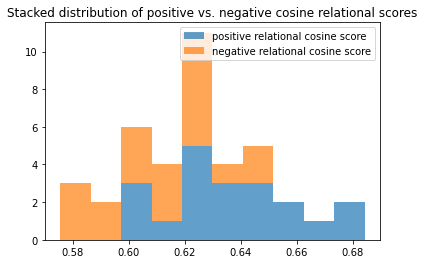

In [21]:
bins = np.arange(0.2,0.5,0.001)
labels = ['positive relational cosine score','negative relational cosine score']

plt.hist([pos_rela['normalized_rela_cos'],neg_rela['normalized_rela_cos']], histtype='bar', alpha = 0.7,stacked=True, label=labels, rwidth=1)
plt.title('Stacked distribution of positive vs. negative cosine relational scores')
plt.legend()



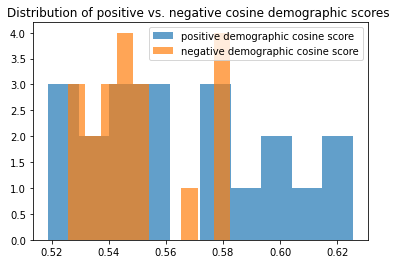

In [22]:
plt.hist(pos_demog['normalized_dem_cos'], label = 'positive demographic cosine score', alpha = 0.7)
plt.hist(neg_demog['normalized_dem_cos'], label = 'negative demographic cosine score', alpha = 0.7)
plt.title('Distribution of positive vs. negative cosine demographic scores ')
plt.legend()
plt.show()

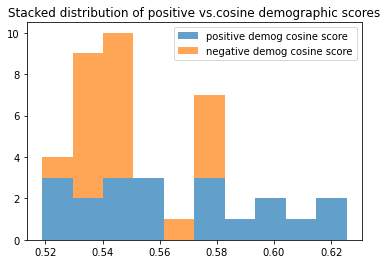

In [23]:
bins = np.arange(0.2,0.5,0.001)
labels = ['positive demog cosine score','negative demog cosine score']

plt.hist([pos_demog['normalized_dem_cos'],neg_demog['normalized_dem_cos']], histtype='bar', alpha = 0.7,stacked=True, label=labels, rwidth=1)
plt.title('Stacked distribution of positive vs.cosine demographic scores')
plt.legend()

